# Árvores de regressão

## Índice <a name="topo"></a>

1. [intuição: Maximizando a gorjeta do garçom](#1)
2. [2. Medida de impureza](#2)
3. [3. Construindo a árvore](#3)
4. [4. Visualizando a árvore](#4)
5. [5. Visualizando a árvore](#4)
6. [6. Visualizando a árvore](#4)

In [1]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

### 1. intuição: Maximizando a gorjeta do garçom<a name="1"></a>

Vamos ilustrar essa seção com o problema da gorjeta do garçom. Vamos montar uma árvore que tente explicar a variabilidade das gorjetas com base em variáveis que permitam montar uma estratégia para o garçom (assumindo que ele tenha uma certa liberdade pra escolher a mesa e o horário de trabalho). O sexo pode entrar como uma variável de controle. Para sexos diferentes podem fazer sentido estratégias diferentes - ou pelo menos pode-se conhecer uma eventual vantagem ou desvantagem na largada.

Note que o valor da conta não se conhece antes de escolher a mesa, portanto não é uma boa variável para se colocar no modelo com esta finalidade.

Quais variáveis mais discriminam a gorjeta? Pra responder a esta pergunta montamos um painelzinho abaixo.

<div style="text-align: right" 
     
[Voltar ao índice](#topo)

In [2]:
tips = sns.load_dataset("tips")
tips['tip_pct'] = tips['tip'] / (tips['total_bill'] - tips['tip'])
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.063204
1,10.34,1.66,Male,No,Sun,Dinner,3,0.191244
2,21.01,3.50,Male,No,Sun,Dinner,3,0.199886
3,23.68,3.31,Male,No,Sun,Dinner,2,0.162494
4,24.59,3.61,Female,No,Sun,Dinner,4,0.172069


C:\Users\eduar\AppData\Local\Temp\ipykernel_11400\1769044393.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax1b = sns.pointplot(x="size", y="tip", data=tips, dodge=True, ci = 90, color = 'navy')
C:\Users\eduar\AppData\Local\Temp\ipykernel_11400\1769044393.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax2b = sns.pointplot(x="day", y="tip", data=tips, dodge=True, ci = 90, color = 'navy')
C:\Users\eduar\AppData\Local\Temp\ipykernel_11400\1769044393.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax3b = sns.pointplot(x="time", y="tip", data=tips, dodge=True, ci = 90, color = 'navy')
C:\Users\eduar\AppData\Local\Temp\ipykernel_11400\1769044393.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax4b = sns.pointplot(x="smoker", y="tip", data=tips, dodge=Tr

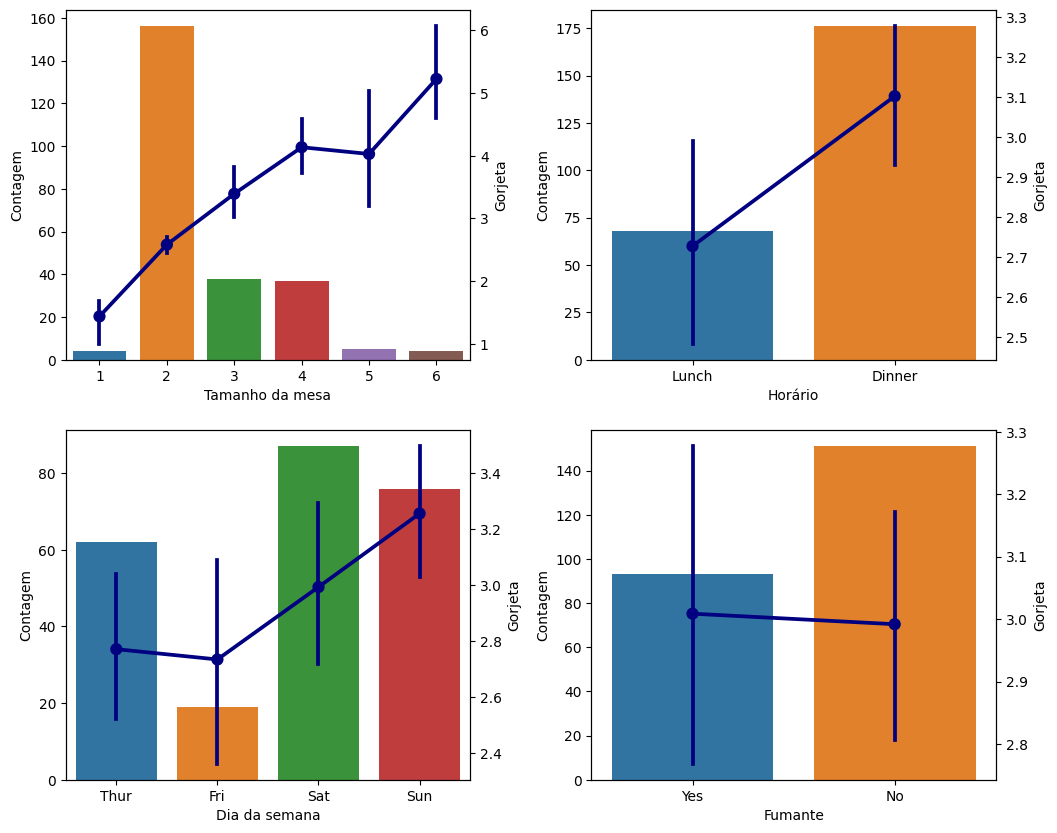

In [3]:
plt.rc('figure', figsize=(12, 10))

fig, axes = plt.subplots(2, 2)

# Gráfico 1: tamanho da mesa
ax1 = axes[0,0]
sns.countplot(x="size", data=tips, dodge=True, ax = ax1)
ax1.set_ylabel("Contagem")
ax1.set_xlabel("Tamanho da mesa")

ax1b = ax1.twinx()
ax1b = sns.pointplot(x="size", y="tip", data=tips, dodge=True, ci = 90, color = 'navy')
plt.ylabel("Gorjeta")

# Gráfico 2: dia da semana
ax2 = axes[1,0]
sns.countplot(x="day", data=tips, dodge=True, ax = ax2)
ax2.set_ylabel("Contagem")
ax2.set_xlabel("Dia da semana")

ax2b = ax2.twinx()
ax2b = sns.pointplot(x="day", y="tip", data=tips, dodge=True, ci = 90, color = 'navy')
plt.ylabel("Gorjeta")

# Gráfico 3: horário
ax3 = axes[0,1]
sns.countplot(x="time", data=tips, dodge=True, ax = ax3)
ax3.set_ylabel("Contagem")
ax3.set_xlabel("Horário")

ax3b = ax3.twinx()
ax3b = sns.pointplot(x="time", y="tip", data=tips, dodge=True, ci = 90, color = 'navy')
plt.ylabel("Gorjeta")

# Gráfico 4: fumante
ax4 = axes[1,1]
sns.countplot(x="smoker", data=tips, dodge=True, ax = ax4)
ax4.set_ylabel("Contagem")
ax4.set_xlabel("Fumante")

ax4b = ax4.twinx()
ax4b = sns.pointplot(x="smoker", y="tip", data=tips, dodge=True, ci = 90, color = 'navy')
plt.ylabel("Gorjeta")

plt.subplots_adjust(wspace=.3, hspace=0.2)



### 2. Medida de impureza<a name="2"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)

Vamos estudar a variável tamanho da mesa, que parece explicar melhor que as demais a gorjeta.

C:\Users\eduar\AppData\Local\Temp\ipykernel_11400\120032618.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax2 = sns.pointplot(x="size", y="tip", data=tips, dodge=True, ci = 90)


Text(0, 0.5, 'Resposta')

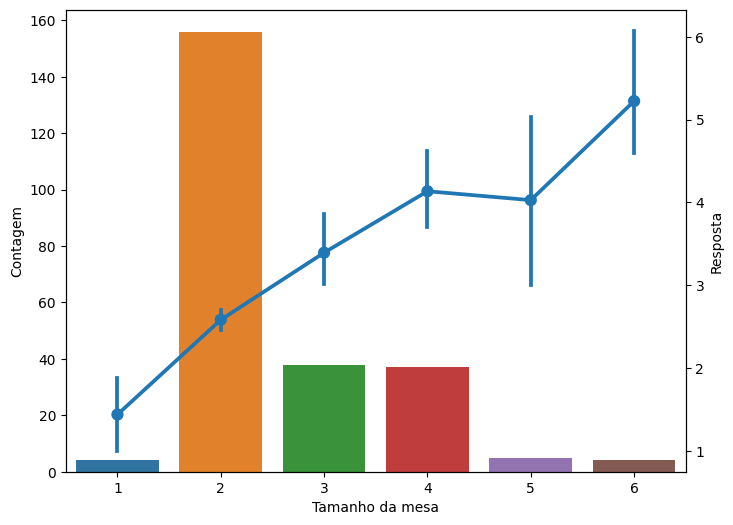

In [4]:
plt.rc('figure', figsize=(8, 6))


ax = sns.countplot(x="size",
                   data=tips, dodge=True)
plt.ylabel("Contagem")
plt.xlabel("Tamanho da mesa")

ax2 = ax.twinx()
ax2 = sns.pointplot(x="size", y="tip", data=tips, dodge=True, ci = 90)
plt.ylabel("Resposta")


#### Medidas de impureza

O que queremos fazer aqui é **explicar a variabilidade** da gorjeta com base nas variáveis que temos disponíveis.A medida mais popular de "impureza" da árvore é o **erro quadrático médio** (MSE - *mean square error* em ingês).

MSE = $\displaystyle\frac{1}{n}\sum_{ x \in c }(x_i - \hat{x})^2 $

Em qu e$\hat{x_i}$ é a estimativa de $x_i$, no caso a média da folha à qual $x_i$ pertence.

C:\Users\eduar\AppData\Local\Temp\ipykernel_11400\2682767031.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.pointplot(x="size", y="tip", data=tips, color='red', ci = None, linestyles='', markers='+')
C:\ProgramData\anaconda3\lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0)]) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


Text(0.5, 0, 'Tamanho da mesa')

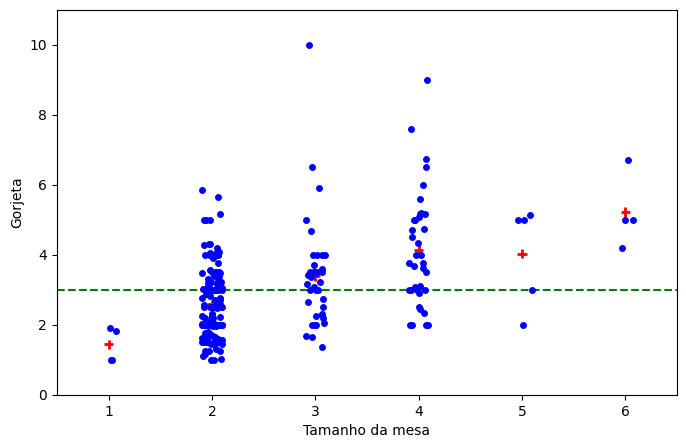

In [5]:
plt.rc('figure', figsize=(8, 5))

ax1 = sns.stripplot(x="size", y="tip", data=tips, color='blue')
ax1.set(ylim=(0, 11))
ax1.axhline(tips['tip'].mean(), ls='--', color = 'green')

ax1.set(ylim=(0, 11))
ax1 = sns.pointplot(x="size", y="tip", data=tips, color='red', ci = None, linestyles='', markers='+')

ax1.set_ylabel("Gorjeta")
ax1.set_xlabel("Tamanho da mesa")

A célula abaixo calcula o erro quadrático médio para cada possível quebra da árvore. Não precisa se preocupar tanto com esse código, já que o scikitlearn já faz essa conta pra nós. Aqui está mais para ilustrarmos como o algoritmo vai fazer para procurar a melhor quebra.

In [6]:
quebra = 2

EQM = []
for quebra in range(tips['size'].max() + 1):
    grupos = pd.cut(tips['size']
                    , bins = [-1, quebra, 99]
                    , labels = ['0 a ' + str(quebra), str(quebra) + ' ou mais'])

    tips_ = tips.copy()
    tips_['grupo'] = grupos

    tips_ = tips_.merge(tips_[['tip', 'grupo']].groupby('grupo').mean()
                        , on = 'grupo'
                        , how = 'left')

    # tips_
    tips_['EQ'] = (tips_['tip_x'] - tips_['tip_y'])**2
    EQM.append(tips_['EQ'].mean())


["{:5.2f}".format(x) for x in EQM]


[' 1.91', ' 1.87', ' 1.53', ' 1.56', ' 1.81', ' 1.82', ' 1.91']

Vemos abaixo que o menor EQM está na quebra **size > 2**.

Text(0.5, 0, 'Tamanho da mesa < X')

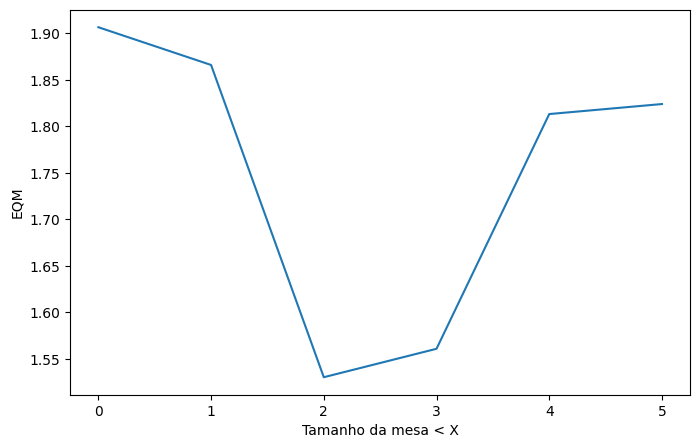

In [7]:
fig = plt.figure()

plt.plot(EQM[0:6])
plt.ylabel("EQM")
plt.xlabel("Tamanho da mesa < X")

### 3. Construindo a árvore<a name="3"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)

#### Dividindo a base em treino e teste

Já vimos que um perigo grande de um algoritmo é o *overfitting*, ou "o algoritmo aprender os dados". Isso significa que o algoritmo não fica geral o suficiente para ser aplicado em uma situação prática. Vimos também que uma forma interessante de evitar isto é dividir a base em uma parte de treinamento, e outra de teste, de modo que podemos avaliar o algoritmo na base de testes, e até fazer algumas modificações no algoritmo com essa base.

Vamos repetir esse passo diversas vezes ainda, então vamos lá:
- vamos colocar a variável "tip" como variável resposta (y)
- as demais variáveis são as preditoras, vão ficar no objeto X.

Lembre-se de que o Scikitlearn não aceita variáveis string nem *missing*. Nesse caso vamos precisar do "get_dummies" para transformar as variáveis qualitativas em variáveis indicadoras, ou variáveis *dummy*.

In [8]:
X = tips.drop(columns = ['total_bill', 'tip', 'tip_pct']).copy()

X = pd.get_dummies(X, drop_first = True)
print(X.info())
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   size         244 non-null    int64
 1   sex_Female   244 non-null    bool 
 2   smoker_No    244 non-null    bool 
 3   day_Fri      244 non-null    bool 
 4   day_Sat      244 non-null    bool 
 5   day_Sun      244 non-null    bool 
 6   time_Dinner  244 non-null    bool 
dtypes: bool(6), int64(1)
memory usage: 3.5 KB
None


,size,sex_Female,smoker_No,day_Fri,day_Sat,day_Sun,time_Dinner
0,2,True,True,False,False,True,True
1,3,False,True,False,False,True,True
2,3,False,True,False,False,True,True
3,2,False,True,False,False,True,True
4,4,True,True,False,False,True,True


In [9]:
y =  tips.loc[:,'tip']

y.head()

0    1.01
1    1.66
2    3.50
3    3.31
4    3.61
Name: tip, dtype: float64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2360873)

In [11]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=8)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8)

In [12]:
# mse1 = mean_squared_error(y_test, regr_1.predict(X_test))
R2_1 = regr_1.score(X_train, y_train)
R2_2 = regr_2.score(X_train, y_train)

template = "O R_Quadrado da árvore com profundidade={0} é: {1:.2f}"

print(template.format(regr_1.get_depth(),R2_1).replace(".",","))
print(template.format(regr_2.get_depth(),R2_2).replace(".",","))


O R_Quadrado da árvore com profundidade=2 é: 0,23
O R_Quadrado da árvore com profundidade=7 é: 0,39


### 4. Visualizando a árvore<a name="4"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)
     
Vamos ver três formas de visualizar a árvore:
     1. Visualizar a forma gráfica da árvore com plot_tree
     2. Visualizar a árvore com graphviz
     2. Representação impressa da árvore
     3. 

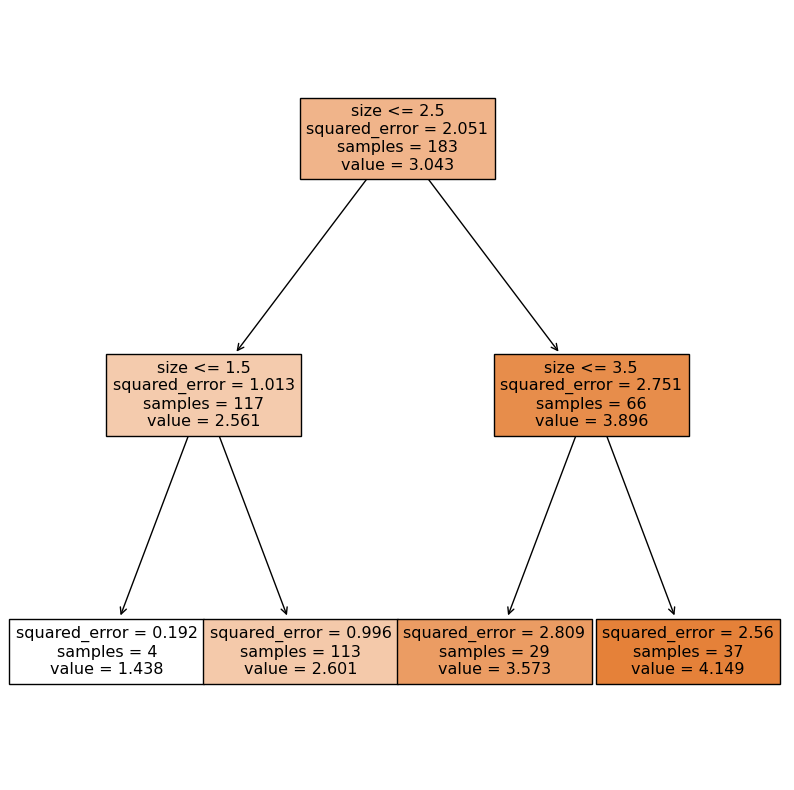

In [13]:
plt.rc('figure', figsize=(10, 10))
tp = tree.plot_tree(regr_1, 
                    feature_names=list(X.columns),  
                    filled=True) 

#### Visualização da forma impressa da árvore

A árvore de regressão pode ser expressa na forma impressa, regra a regra com o comando abaixo:

In [14]:
representacao_textual = tree.export_text(regr_1)
print(representacao_textual)

|--- feature_0 <= 2.50
|   |--- feature_0 <= 1.50
|   |   |--- value: [1.44]
|   |--- feature_0 >  1.50
|   |   |--- value: [2.60]
|--- feature_0 >  2.50
|   |--- feature_0 <= 3.50
|   |   |--- value: [3.57]
|   |--- feature_0 >  3.50
|   |   |--- value: [4.15]



#### Instalando o graphviz e o dtreeviz

Ambos os pacotes não são essenciais para o nosso curso, mas fornecem recursos interessantes de visualização de árvores. Não cobriremos em detalhes a instalação desses pacotes, mas as instruções se encontram nesse [link](https://github.com/parrt/dtreeviz)

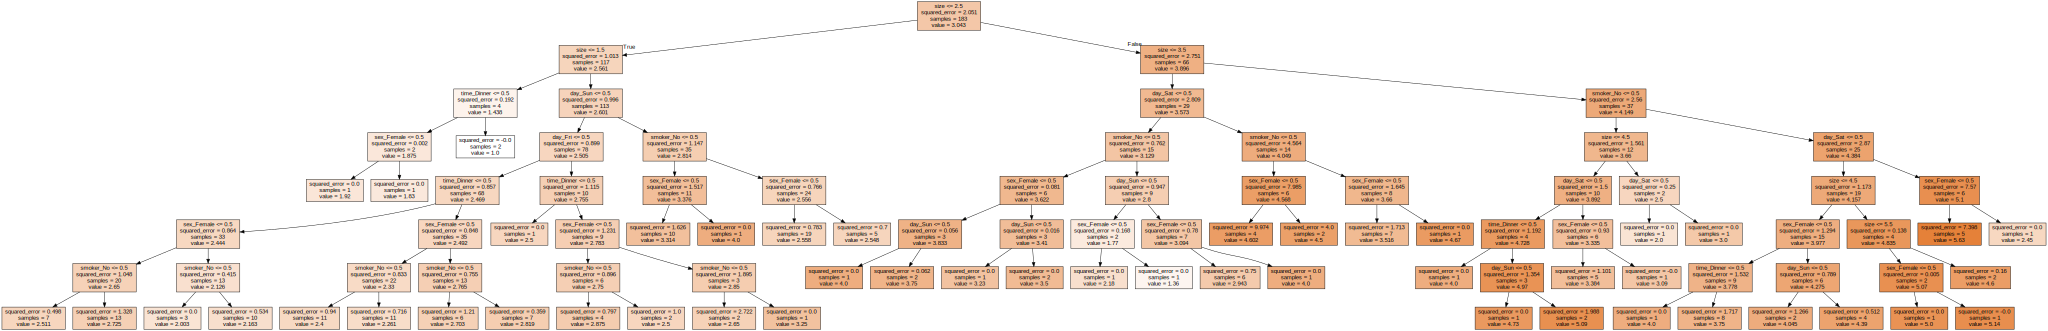

In [15]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(regr_2, out_file=None, 
                                feature_names=X.columns,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


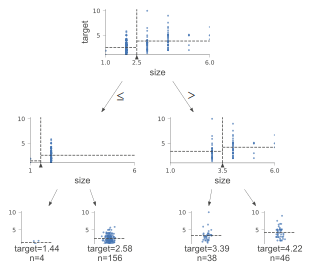

In [16]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

import dtreeviz # remember to load the package

dtreeviz.model(regr_1, X, y,
                target_name="target",
                feature_names=X.columns).view()

###  5. Pré-poda<a name="5"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)
     

In [17]:
regr_1 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10)

regr_1.fit(X_train, y_train)

mse1 = regr_1.score(X_test, y_test)
mse1

0.2392376384366276

n_minimo,2,3,4,5,6,7,8,9
profundidade,,,,,,,,
2,0.253436,0.253436,0.253436,0.259370,0.259370,0.259370,0.259370,0.259370
3,0.248468,0.248468,0.248468,0.239238,0.239238,0.239238,0.239238,0.239238
4,0.245427,0.251741,0.251741,0.253258,0.240488,0.241253,0.241253,0.241253
5,0.286960,0.303885,0.304463,0.222814,0.203486,0.229503,0.229503,0.229503
6,0.248086,0.286307,0.286307,0.192430,0.186827,0.205677,0.221031,0.221031
7,0.226581,0.264802,0.272560,0.192430,0.179660,0.212844,0.227590,0.221031
8,0.226581,0.257254,0.264299,0.192430,0.186827,0.205677,0.227590,0.221031


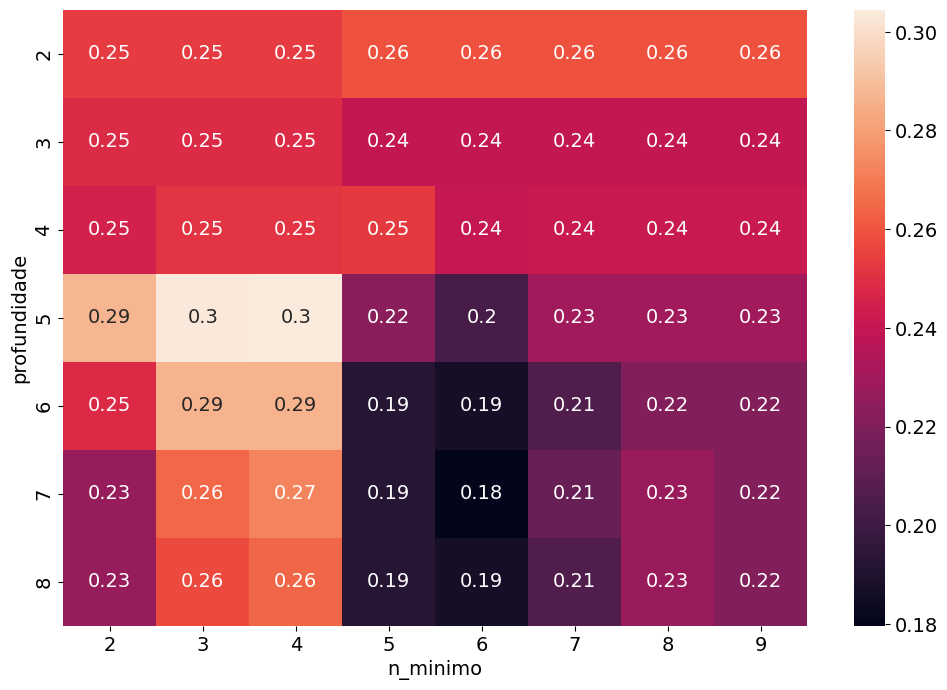

In [18]:
mses = []
ind_i = []
ind_j = []

for i in range(2, 9):
    for j in range(2, 10):
        regr_1 = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
        regr_1.fit(X_train, y_train)
        mse1 = regr_1.score(X_test, y_test)
        mses.append(mse1)
        ind_i.append(i)
        ind_j.append(j)
        
df_mse = pd.DataFrame({'mses':mses, 'profundidade':ind_i, 'n_minimo':ind_j})
sns.heatmap(df_mse.pivot(index='profundidade', columns='n_minimo', values='mses'), annot=True)
df_mse.pivot(index='profundidade', columns='n_minimo', values='mses')

### 6. Pós-poda<a name="6"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)
     

In [19]:
path = regr_2.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.00000000e+00, 2.34900777e-06, 2.21311475e-05, 5.35519126e-05,
        7.65482696e-05, 2.27686703e-04, 2.34448248e-04, 2.65573770e-04,
        3.03582271e-04, 3.21481014e-04, 3.93606557e-04, 4.72131148e-04,
        5.81445604e-04, 7.10040984e-04, 8.67213115e-04, 1.13817600e-03,
        1.20710383e-03, 1.46894353e-03, 1.83715847e-03, 2.33778440e-03,
        2.73224044e-03, 3.85614754e-03, 4.18374317e-03, 4.86353977e-03,
        5.22971637e-03, 6.10091153e-03, 6.37064793e-03, 1.27133065e-02,
        1.40943130e-02, 1.54579755e-02, 2.01481897e-02, 2.15387295e-02,
        2.85768555e-02, 3.04630024e-02, 3.14966462e-02, 4.10774125e-01]),
 'impurities': array([1.25120884, 1.25121119, 1.25123332, 1.25128687, 1.25136342,
        1.25159111, 1.25182556, 1.25209113, 1.25239471, 1.25271619,
        1.2531098 , 1.25358193, 1.25416338, 1.25700354, 1.25787075,
        1.25900893, 1.26021603, 1.26168498, 1.26352214, 1.26585992,
        1.26859216, 1.27244831, 1.27663205, 1.2814

Text(0, 0.5, 'Impureza total das folhas')

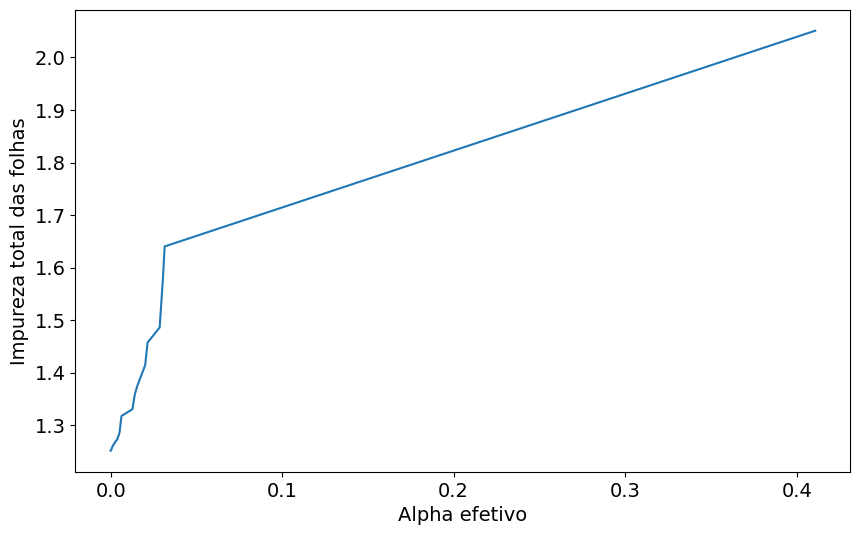

In [20]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("Alpha efetivo")
plt.ylabel("Impureza total das folhas")

In [21]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'Profundidade da árvore')

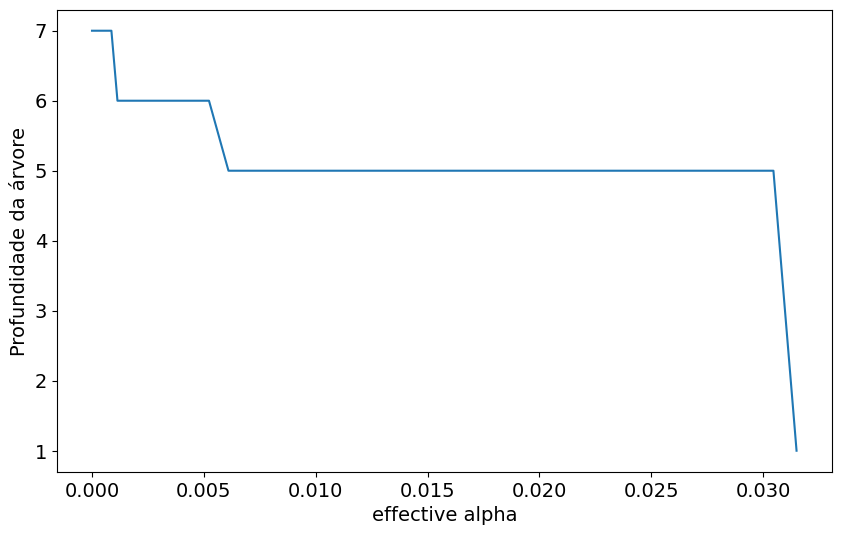

In [22]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Profundidade da árvore")

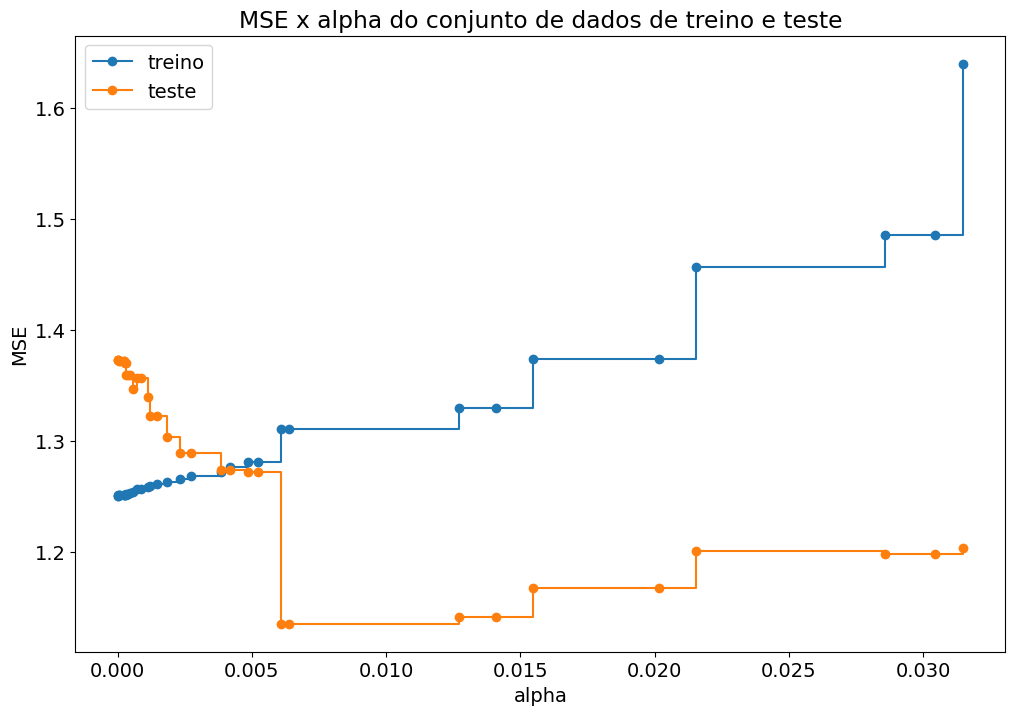

In [23]:
train_scores = [mean_squared_error(y_train , clf.predict(X_train)) for clf in clfs]
test_scores  = [mean_squared_error(y_test  , clf.predict(X_test )) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

#### Exemplo intuitivo de pós-poda

Exemplo do [scikitlearn](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py).

In [24]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

In [25]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

DecisionTreeRegressor(max_depth=5)

In [26]:
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

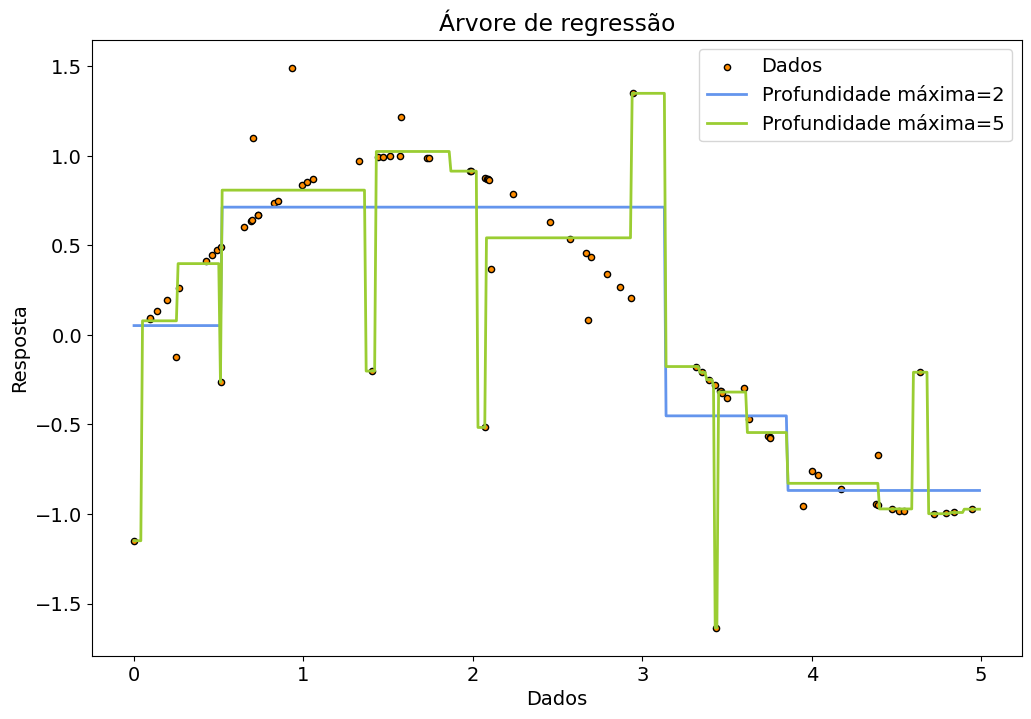

In [27]:
# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="Dados")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="Profundidade máxima=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="Profundidade máxima=5", linewidth=2)
plt.xlabel("Dados")
plt.ylabel("Resposta")
plt.title("Árvore de regressão")
plt.legend()
plt.show()